In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 198)
(463113, 1)
validation
(87055, 198)
(87055, 1)
test
(43409, 198)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 892929 (3.41 MB)


Trainable params: 892929 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



 1/47 [..............................] - ETA: 1:01 - loss: 0.0159 - STD: 8.0903e-05 - MAE: 0.1081


 5/47 [==>...........................] - ETA: 0s - loss: 0.0157 - STD: 4.4749e-05 - MAE: 0.0938  


 9/47 [====>.........................] - ETA: 0s - loss: 0.0148 - STD: 8.7070e-05 - MAE: 0.0953


13/47 [=======>......................] - ETA: 2s - loss: 0.0143 - STD: 1.2206e-04 - MAE: 0.0918


17/47 [=========>....................] - ETA: 1s - loss: 0.0138 - STD: 1.6390e-04 - MAE: 0.0903


22/47 [=============>................] - ETA: 1s - loss: 0.0135 - STD: 2.2004e-04 - MAE: 0.0901


27/47 [================>.............] - ETA: 0s - loss: 0.0133 - STD: 2.6407e-04 - MAE: 0.0888


32/47 [===================>..........] - ETA: 0s - loss: 0.0131 - STD: 3.1677e-04 - MAE: 0.0885


36/47 [=====================>........] - ETA: 0s - loss: 0.0130 - STD: 3.5894e-04 - MAE: 0.0882


40/47 [========================>.....] - ETA: 0s - loss: 0.0129 - STD: 4.0238e-04 - MAE: 0.0878


45/47 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 4.6830e-04 - MAE: 0.0876


47/47 [==============================] - 3s 41ms/step - loss: 0.0127 - STD: 4.9663e-04 - MAE: 0.0874 - val_loss: 0.0141 - val_STD: 0.0012 - val_MAE: 0.0916


Epoch 2/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0120 - STD: 0.0012 - MAE: 0.0835


 6/47 [==>...........................] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0841


11/47 [======>.......................] - ETA: 0s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0850


15/47 [========>.....................] - ETA: 0s - loss: 0.0119 - STD: 0.0017 - MAE: 0.0845


20/47 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 0.0020 - MAE: 0.0847


25/47 [==============>...............] - ETA: 0s - loss: 0.0118 - STD: 0.0024 - MAE: 0.0844


30/47 [==================>...........] - ETA: 0s - loss: 0.0118 - STD: 0.0030 - MAE: 0.0844


35/47 [=====================>........] - ETA: 0s - loss: 0.0117 - STD: 0.0038 - MAE: 0.0841


40/47 [========================>.....] - ETA: 0s - loss: 0.0116 - STD: 0.0050 - MAE: 0.0839


45/47 [===========================>..] - ETA: 0s - loss: 0.0115 - STD: 0.0067 - MAE: 0.0835


47/47 [==============================] - 1s 14ms/step - loss: 0.0114 - STD: 0.0076 - MAE: 0.0832 - val_loss: 0.0118 - val_STD: 0.0302 - val_MAE: 0.0853


Epoch 3/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0096 - STD: 0.0303 - MAE: 0.0761


 6/47 [==>...........................] - ETA: 0s - loss: 0.0097 - STD: 0.0373 - MAE: 0.0771


10/47 [=====>........................] - ETA: 0s - loss: 0.0096 - STD: 0.0420 - MAE: 0.0767


15/47 [========>.....................] - ETA: 0s - loss: 0.0096 - STD: 0.0461 - MAE: 0.0764


20/47 [===========>..................] - ETA: 0s - loss: 0.0095 - STD: 0.0485 - MAE: 0.0760


25/47 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 0.0493 - MAE: 0.0757


30/47 [==================>...........] - ETA: 0s - loss: 0.0094 - STD: 0.0494 - MAE: 0.0756


35/47 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0494 - MAE: 0.0753


40/47 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0495 - MAE: 0.0751


45/47 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0498 - MAE: 0.0747


47/47 [==============================] - 1s 14ms/step - loss: 0.0093 - STD: 0.0500 - MAE: 0.0747 - val_loss: 0.0104 - val_STD: 0.0519 - val_MAE: 0.0793


Epoch 4/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0086 - STD: 0.0527 - MAE: 0.0710


 6/47 [==>...........................] - ETA: 0s - loss: 0.0087 - STD: 0.0541 - MAE: 0.0718


11/47 [======>.......................] - ETA: 0s - loss: 0.0087 - STD: 0.0549 - MAE: 0.0718


16/47 [=========>....................] - ETA: 0s - loss: 0.0086 - STD: 0.0553 - MAE: 0.0714


21/47 [============>.................] - ETA: 0s - loss: 0.0086 - STD: 0.0556 - MAE: 0.0712


26/47 [===============>..............] - ETA: 0s - loss: 0.0085 - STD: 0.0560 - MAE: 0.0710


31/47 [==================>...........] - ETA: 0s - loss: 0.0085 - STD: 0.0559 - MAE: 0.0707


36/47 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.0561 - MAE: 0.0707


40/47 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.0561 - MAE: 0.0706


45/47 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.0564 - MAE: 0.0703


47/47 [==============================] - 1s 15ms/step - loss: 0.0084 - STD: 0.0565 - MAE: 0.0702 - val_loss: 0.0088 - val_STD: 0.0583 - val_MAE: 0.0725


Epoch 5/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0077 - STD: 0.0599 - MAE: 0.0668


 6/47 [==>...........................] - ETA: 0s - loss: 0.0079 - STD: 0.0608 - MAE: 0.0676


11/47 [======>.......................] - ETA: 0s - loss: 0.0079 - STD: 0.0613 - MAE: 0.0675


15/47 [========>.....................] - ETA: 0s - loss: 0.0078 - STD: 0.0616 - MAE: 0.0672


19/47 [===========>..................] - ETA: 0s - loss: 0.0078 - STD: 0.0619 - MAE: 0.0670


23/47 [=============>................] - ETA: 0s - loss: 0.0078 - STD: 0.0622 - MAE: 0.0669


27/47 [================>.............] - ETA: 0s - loss: 0.0078 - STD: 0.0621 - MAE: 0.0669


32/47 [===================>..........] - ETA: 0s - loss: 0.0078 - STD: 0.0622 - MAE: 0.0667


37/47 [======================>.......] - ETA: 0s - loss: 0.0077 - STD: 0.0625 - MAE: 0.0666


42/47 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0627 - MAE: 0.0665


47/47 [==============================] - ETA: 0s - loss: 0.0077 - STD: 0.0630 - MAE: 0.0664


47/47 [==============================] - 1s 15ms/step - loss: 0.0077 - STD: 0.0630 - MAE: 0.0664 - val_loss: 0.0088 - val_STD: 0.0579 - val_MAE: 0.0686


Epoch 6/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0079 - STD: 0.0597 - MAE: 0.0644


 5/47 [==>...........................] - ETA: 0s - loss: 0.0075 - STD: 0.0650 - MAE: 0.0650


 9/47 [====>.........................] - ETA: 0s - loss: 0.0074 - STD: 0.0655 - MAE: 0.0647


13/47 [=======>......................] - ETA: 0s - loss: 0.0074 - STD: 0.0661 - MAE: 0.0649


17/47 [=========>....................] - ETA: 0s - loss: 0.0074 - STD: 0.0662 - MAE: 0.0647


22/47 [=============>................] - ETA: 0s - loss: 0.0074 - STD: 0.0664 - MAE: 0.0644


27/47 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.0667 - MAE: 0.0642


31/47 [==================>...........] - ETA: 0s - loss: 0.0073 - STD: 0.0666 - MAE: 0.0641


35/47 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0667 - MAE: 0.0645


40/47 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0645


45/47 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0666 - MAE: 0.0644


47/47 [==============================] - 1s 15ms/step - loss: 0.0074 - STD: 0.0666 - MAE: 0.0643 - val_loss: 0.0076 - val_STD: 0.0654 - val_MAE: 0.0660


Epoch 7/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0074 - STD: 0.0678 - MAE: 0.0643


 6/47 [==>...........................] - ETA: 0s - loss: 0.0071 - STD: 0.0677 - MAE: 0.0633


11/47 [======>.......................] - ETA: 0s - loss: 0.0071 - STD: 0.0677 - MAE: 0.0632


16/47 [=========>....................] - ETA: 0s - loss: 0.0071 - STD: 0.0681 - MAE: 0.0633


21/47 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.0679 - MAE: 0.0636


26/47 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.0677 - MAE: 0.0639


31/47 [==================>...........] - ETA: 0s - loss: 0.0073 - STD: 0.0678 - MAE: 0.0640


36/47 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0677 - MAE: 0.0639


41/47 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0677 - MAE: 0.0637


46/47 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0678 - MAE: 0.0636


47/47 [==============================] - 1s 14ms/step - loss: 0.0072 - STD: 0.0678 - MAE: 0.0636 - val_loss: 0.0074 - val_STD: 0.0690 - val_MAE: 0.0656


Epoch 8/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0069 - STD: 0.0718 - MAE: 0.0635


 6/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0697 - MAE: 0.0629


11/47 [======>.......................] - ETA: 0s - loss: 0.0071 - STD: 0.0696 - MAE: 0.0628


15/47 [========>.....................] - ETA: 0s - loss: 0.0071 - STD: 0.0698 - MAE: 0.0629


20/47 [===========>..................] - ETA: 0s - loss: 0.0071 - STD: 0.0700 - MAE: 0.0628


25/47 [==============>...............] - ETA: 0s - loss: 0.0070 - STD: 0.0701 - MAE: 0.0628


30/47 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.0702 - MAE: 0.0628


34/47 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0700 - MAE: 0.0628


38/47 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0698 - MAE: 0.0630


42/47 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0699 - MAE: 0.0637


46/47 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0691 - MAE: 0.0646


47/47 [==============================] - 1s 14ms/step - loss: 0.0075 - STD: 0.0687 - MAE: 0.0647 - val_loss: 0.0106 - val_STD: 0.0481 - val_MAE: 0.0735


Epoch 9/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0087 - STD: 0.0494 - MAE: 0.0657


 5/47 [==>...........................] - ETA: 0s - loss: 0.0084 - STD: 0.0575 - MAE: 0.0684


 9/47 [====>.........................] - ETA: 0s - loss: 0.0081 - STD: 0.0581 - MAE: 0.0682


14/47 [=======>......................] - ETA: 0s - loss: 0.0080 - STD: 0.0576 - MAE: 0.0677


19/47 [===========>..................] - ETA: 0s - loss: 0.0078 - STD: 0.0580 - MAE: 0.0669


24/47 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0588 - MAE: 0.0664


28/47 [================>.............] - ETA: 0s - loss: 0.0076 - STD: 0.0597 - MAE: 0.0661


33/47 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0607 - MAE: 0.0657


37/47 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0616 - MAE: 0.0655


42/47 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0624 - MAE: 0.0651


47/47 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.0631 - MAE: 0.0648


47/47 [==============================] - 1s 15ms/step - loss: 0.0074 - STD: 0.0631 - MAE: 0.0648 - val_loss: 0.0074 - val_STD: 0.0681 - val_MAE: 0.0652


Epoch 10/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0070 - STD: 0.0708 - MAE: 0.0632


 5/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0693 - MAE: 0.0624


10/47 [=====>........................] - ETA: 0s - loss: 0.0070 - STD: 0.0693 - MAE: 0.0623


14/47 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0696 - MAE: 0.0621


18/47 [==========>...................] - ETA: 0s - loss: 0.0069 - STD: 0.0698 - MAE: 0.0621


22/47 [=============>................] - ETA: 0s - loss: 0.0069 - STD: 0.0699 - MAE: 0.0621


27/47 [================>.............] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0621


32/47 [===================>..........] - ETA: 0s - loss: 0.0069 - STD: 0.0705 - MAE: 0.0621


36/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0706 - MAE: 0.0620


40/47 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0707 - MAE: 0.0620


44/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0708 - MAE: 0.0620


47/47 [==============================] - 1s 15ms/step - loss: 0.0069 - STD: 0.0708 - MAE: 0.0620 - val_loss: 0.0074 - val_STD: 0.0685 - val_MAE: 0.0642


Epoch 11/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0069 - STD: 0.0717 - MAE: 0.0621


 6/47 [==>...........................] - ETA: 0s - loss: 0.0069 - STD: 0.0711 - MAE: 0.0618


10/47 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0713 - MAE: 0.0620


15/47 [========>.....................] - ETA: 0s - loss: 0.0069 - STD: 0.0715 - MAE: 0.0618


20/47 [===========>..................] - ETA: 0s - loss: 0.0068 - STD: 0.0716 - MAE: 0.0616


25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0616


30/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0616


34/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0718 - MAE: 0.0618


39/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0717 - MAE: 0.0617


44/47 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0617


47/47 [==============================] - 1s 15ms/step - loss: 0.0068 - STD: 0.0717 - MAE: 0.0617 - val_loss: 0.0073 - val_STD: 0.0682 - val_MAE: 0.0641


Epoch 12/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0615


 6/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0709 - MAE: 0.0612


11/47 [======>.......................] - ETA: 0s - loss: 0.0068 - STD: 0.0710 - MAE: 0.0613


16/47 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0615


21/47 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0615


25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0715 - MAE: 0.0615


29/47 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0717 - MAE: 0.0617


34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0717 - MAE: 0.0616


38/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0616


42/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0719 - MAE: 0.0615


46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0719 - MAE: 0.0615


47/47 [==============================] - 1s 14ms/step - loss: 0.0068 - STD: 0.0719 - MAE: 0.0615 - val_loss: 0.0077 - val_STD: 0.0654 - val_MAE: 0.0649


Epoch 13/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0069 - STD: 0.0680 - MAE: 0.0612


 5/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0707 - MAE: 0.0613


10/47 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0714 - MAE: 0.0619


15/47 [========>.....................] - ETA: 0s - loss: 0.0069 - STD: 0.0716 - MAE: 0.0620


20/47 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0709 - MAE: 0.0621


25/47 [==============>...............] - ETA: 0s - loss: 0.0070 - STD: 0.0708 - MAE: 0.0623


29/47 [=================>............] - ETA: 0s - loss: 0.0070 - STD: 0.0705 - MAE: 0.0622


34/47 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0705 - MAE: 0.0623


39/47 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0702 - MAE: 0.0622


44/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0622


47/47 [==============================] - 1s 14ms/step - loss: 0.0069 - STD: 0.0702 - MAE: 0.0622 - val_loss: 0.0071 - val_STD: 0.0696 - val_MAE: 0.0640


Epoch 14/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0732 - MAE: 0.0619


 6/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0709 - MAE: 0.0613


11/47 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0613


16/47 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0715 - MAE: 0.0613


21/47 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0614


26/47 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0613


31/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0613


36/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0719 - MAE: 0.0614


41/47 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0613


46/47 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0613


47/47 [==============================] - 1s 14ms/step - loss: 0.0068 - STD: 0.0718 - MAE: 0.0613 - val_loss: 0.0072 - val_STD: 0.0695 - val_MAE: 0.0639


Epoch 15/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0727 - MAE: 0.0613


 5/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0723 - MAE: 0.0612


 9/47 [====>.........................] - ETA: 0s - loss: 0.0067 - STD: 0.0722 - MAE: 0.0611


13/47 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0723 - MAE: 0.0609


17/47 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0609


22/47 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0723 - MAE: 0.0608


27/47 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0724 - MAE: 0.0609


32/47 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0613


37/47 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0721 - MAE: 0.0615


42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0719 - MAE: 0.0618


47/47 [==============================] - ETA: 0s - loss: 0.0069 - STD: 0.0715 - MAE: 0.0618


47/47 [==============================] - 1s 15ms/step - loss: 0.0069 - STD: 0.0715 - MAE: 0.0618 - val_loss: 0.0071 - val_STD: 0.0685 - val_MAE: 0.0647


Epoch 16/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0071 - STD: 0.0732 - MAE: 0.0643


 6/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0692 - MAE: 0.0620


11/47 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0692 - MAE: 0.0615


16/47 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0700 - MAE: 0.0613


21/47 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0704 - MAE: 0.0613


26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0709 - MAE: 0.0612


31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0712 - MAE: 0.0612


36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0713 - MAE: 0.0611


41/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0612


45/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0612


47/47 [==============================] - 1s 14ms/step - loss: 0.0067 - STD: 0.0716 - MAE: 0.0612 - val_loss: 0.0081 - val_STD: 0.0629 - val_MAE: 0.0662


Epoch 17/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0666 - MAE: 0.0597


 6/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0722 - MAE: 0.0617


11/47 [======>.......................] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0615


16/47 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0614


21/47 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0612


26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0716 - MAE: 0.0613


31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0611


36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0717 - MAE: 0.0612


41/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0718 - MAE: 0.0611


46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0720 - MAE: 0.0611


47/47 [==============================] - 1s 14ms/step - loss: 0.0067 - STD: 0.0720 - MAE: 0.0611 - val_loss: 0.0071 - val_STD: 0.0713 - val_MAE: 0.0638


Epoch 18/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0070 - STD: 0.0764 - MAE: 0.0627


 6/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0734 - MAE: 0.0607


11/47 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0607


16/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0608


21/47 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0732 - MAE: 0.0608


26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0732 - MAE: 0.0608


31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0730 - MAE: 0.0607


36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0730 - MAE: 0.0608


40/47 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0730 - MAE: 0.0608


45/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0731 - MAE: 0.0607


47/47 [==============================] - 1s 14ms/step - loss: 0.0067 - STD: 0.0731 - MAE: 0.0607 - val_loss: 0.0073 - val_STD: 0.0684 - val_MAE: 0.0640


Epoch 19/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0597


 6/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0734 - MAE: 0.0605


11/47 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0604


16/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0606


21/47 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0730 - MAE: 0.0607


26/47 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0610


31/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0728 - MAE: 0.0612


36/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0719 - MAE: 0.0615


41/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0716 - MAE: 0.0619


46/47 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.0710 - MAE: 0.0619


47/47 [==============================] - 1s 14ms/step - loss: 0.0069 - STD: 0.0708 - MAE: 0.0619 - val_loss: 0.0072 - val_STD: 0.0708 - val_MAE: 0.0660


Epoch 20/10000



 1/47 [..............................] - ETA: 0s - loss: 0.0071 - STD: 0.0756 - MAE: 0.0668


 6/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0689 - MAE: 0.0629


11/47 [======>.......................] - ETA: 0s - loss: 0.0069 - STD: 0.0686 - MAE: 0.0621


15/47 [========>.....................] - ETA: 0s - loss: 0.0069 - STD: 0.0692 - MAE: 0.0621


20/47 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0698 - MAE: 0.0620


25/47 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0697 - MAE: 0.0617


30/47 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0702 - MAE: 0.0616


35/47 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0705 - MAE: 0.0615


40/47 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0707 - MAE: 0.0613


45/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0710 - MAE: 0.0613


47/47 [==============================] - 1s 14ms/step - loss: 0.0067 - STD: 0.0710 - MAE: 0.0612 - val_loss: 0.0070 - val_STD: 0.0724 - val_MAE: 0.0638


Epoch 21/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0770 - MAE: 0.0617


 5/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0742 - MAE: 0.0610


 9/47 [====>.........................] - ETA: 0s - loss: 0.0067 - STD: 0.0738 - MAE: 0.0607


14/47 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0737 - MAE: 0.0606


19/47 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0737 - MAE: 0.0605


24/47 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0605


29/47 [=================>............] - ETA: 0s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0605


34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0604


39/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0736 - MAE: 0.0603


44/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0603


47/47 [==============================] - 1s 14ms/step - loss: 0.0066 - STD: 0.0736 - MAE: 0.0603 - val_loss: 0.0076 - val_STD: 0.0662 - val_MAE: 0.0648


Epoch 22/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0712 - MAE: 0.0601


 6/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0740 - MAE: 0.0605


11/47 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0604


16/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0604


21/47 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0603


26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0603


31/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0732 - MAE: 0.0603


36/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0603


41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0603


46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0734 - MAE: 0.0603


47/47 [==============================] - 1s 14ms/step - loss: 0.0066 - STD: 0.0733 - MAE: 0.0603 - val_loss: 0.0071 - val_STD: 0.0713 - val_MAE: 0.0636


Epoch 23/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0761 - MAE: 0.0608


 5/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0742 - MAE: 0.0602


10/47 [=====>........................] - ETA: 0s - loss: 0.0066 - STD: 0.0744 - MAE: 0.0603


15/47 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0743 - MAE: 0.0601


20/47 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0743 - MAE: 0.0602


25/47 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0742 - MAE: 0.0602


30/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0740 - MAE: 0.0602


35/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0740 - MAE: 0.0603


40/47 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0740 - MAE: 0.0604


45/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0603


47/47 [==============================] - 1s 14ms/step - loss: 0.0066 - STD: 0.0737 - MAE: 0.0604 - val_loss: 0.0075 - val_STD: 0.0658 - val_MAE: 0.0645


Epoch 24/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0701 - MAE: 0.0590


 6/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0721 - MAE: 0.0607


11/47 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0724 - MAE: 0.0606


16/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0724 - MAE: 0.0605


21/47 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0604


26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0604


31/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0604


36/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0603


41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0603


46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0603


47/47 [==============================] - 1s 14ms/step - loss: 0.0066 - STD: 0.0731 - MAE: 0.0603 - val_loss: 0.0074 - val_STD: 0.0685 - val_MAE: 0.0641


Epoch 25/10000



 1/47 [..............................] - ETA: 0s - loss: 0.0062 - STD: 0.0726 - MAE: 0.0589


 6/47 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0738 - MAE: 0.0596


11/47 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0740 - MAE: 0.0596


16/47 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0742 - MAE: 0.0597


21/47 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0598


26/47 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0598


31/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0742 - MAE: 0.0599


36/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0599


41/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0599


46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0599


47/47 [==============================] - 1s 14ms/step - loss: 0.0065 - STD: 0.0742 - MAE: 0.0599 - val_loss: 0.0073 - val_STD: 0.0687 - val_MAE: 0.0639


Epoch 26/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0597


 5/47 [==>...........................] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0601


 9/47 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0736 - MAE: 0.0600


14/47 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0600


19/47 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0737 - MAE: 0.0601


24/47 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0739 - MAE: 0.0601


29/47 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0738 - MAE: 0.0600


34/47 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0738 - MAE: 0.0600


38/47 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0739 - MAE: 0.0602


43/47 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0736 - MAE: 0.0602


47/47 [==============================] - 1s 14ms/step - loss: 0.0066 - STD: 0.0737 - MAE: 0.0603 - val_loss: 0.0093 - val_STD: 0.0571 - val_MAE: 0.0699


Epoch 27/10000



 1/47 [..............................] - ETA: 1s - loss: 0.0075 - STD: 0.0608 - MAE: 0.0613


 6/47 [==>...........................] - ETA: 0s - loss: 0.0076 - STD: 0.0710 - MAE: 0.0650


11/47 [======>.......................] - ETA: 0s - loss: 0.0078 - STD: 0.0663 - MAE: 0.0656


16/47 [=========>....................] - ETA: 0s - loss: 0.0076 - STD: 0.0648 - MAE: 0.0650


21/47 [============>.................] - ETA: 0s - loss: 0.0074 - STD: 0.0645 - MAE: 0.0648


26/47 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.0649 - MAE: 0.0642


31/47 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.0656 - MAE: 0.0638


36/47 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0666 - MAE: 0.0633


41/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0674 - MAE: 0.0629


46/47 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.0680 - MAE: 0.0626


47/47 [==============================] - 1s 14ms/step - loss: 0.0070 - STD: 0.0681 - MAE: 0.0625 - val_loss: 0.0076 - val_STD: 0.0659 - val_MAE: 0.0645


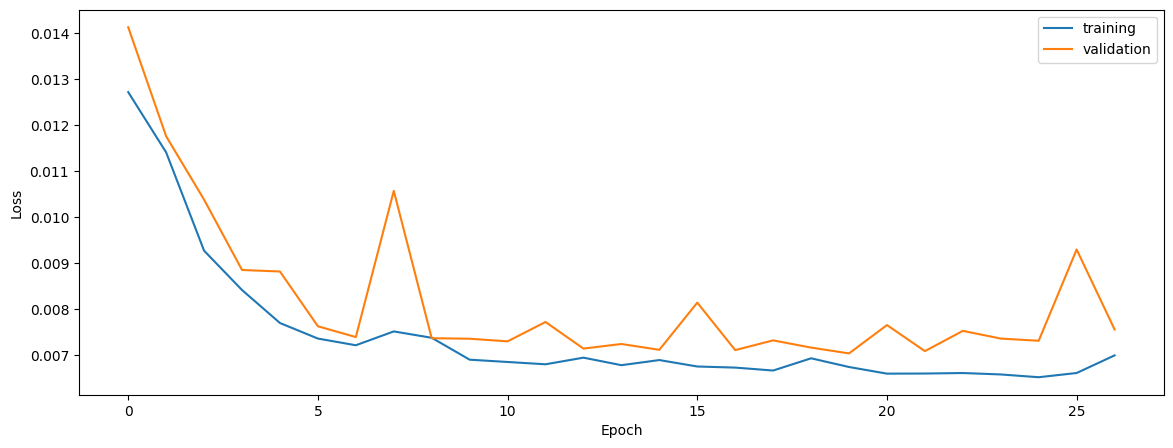

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6729105192264275
0.7028590017122175
0.5950332793310027


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6736637439583033
0.6884826939423566
0.6479060264409675


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6759829703395964
0.6889390505773481
0.6570714319017428


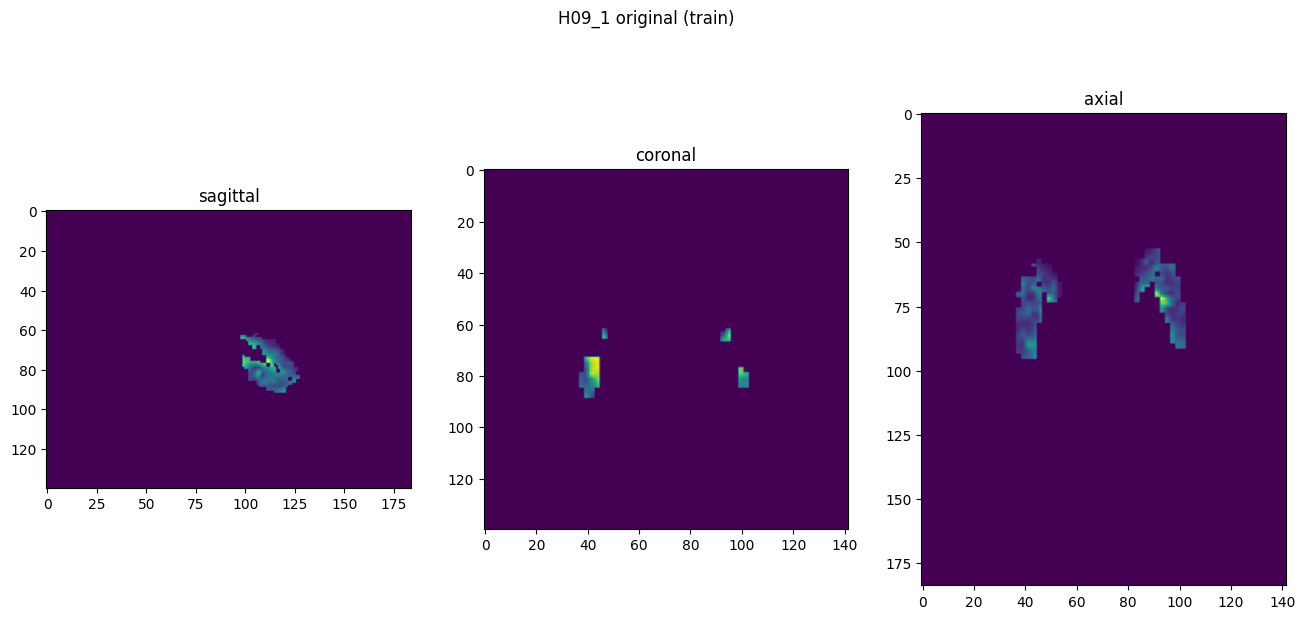

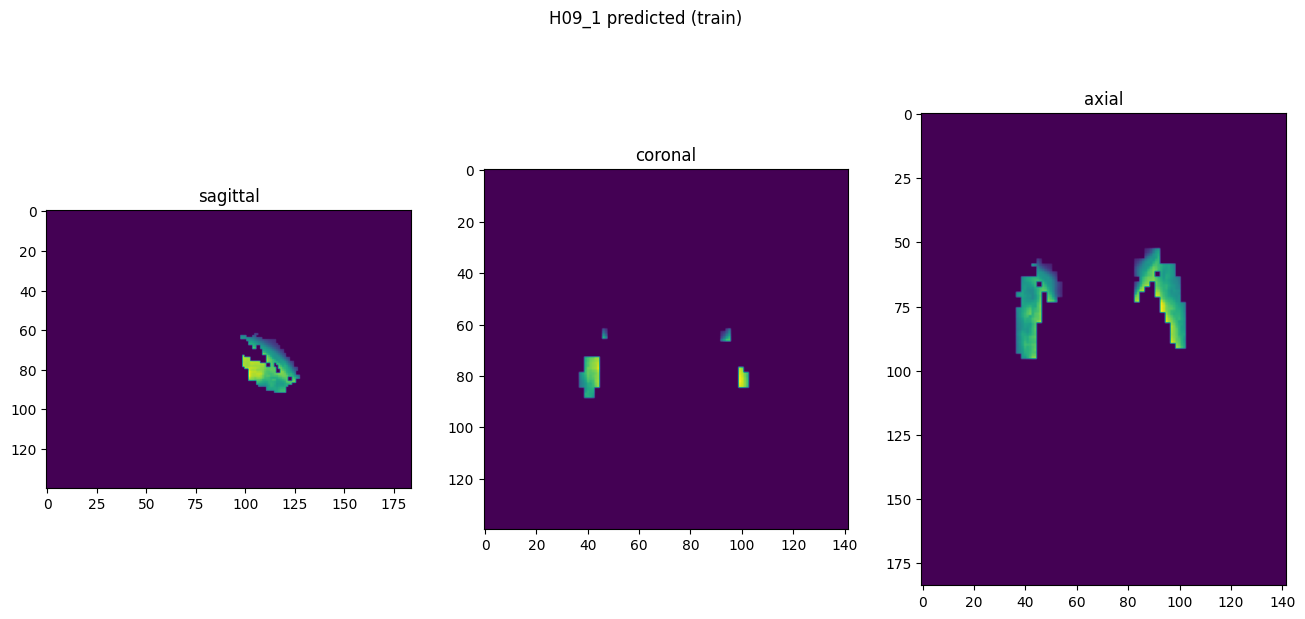

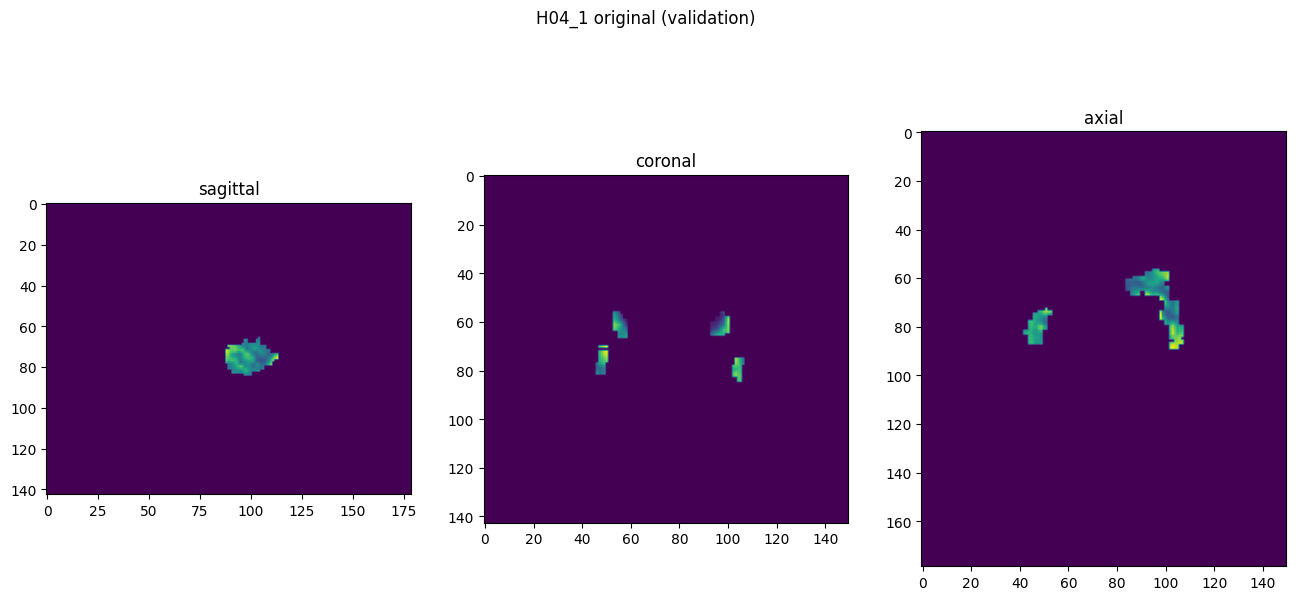

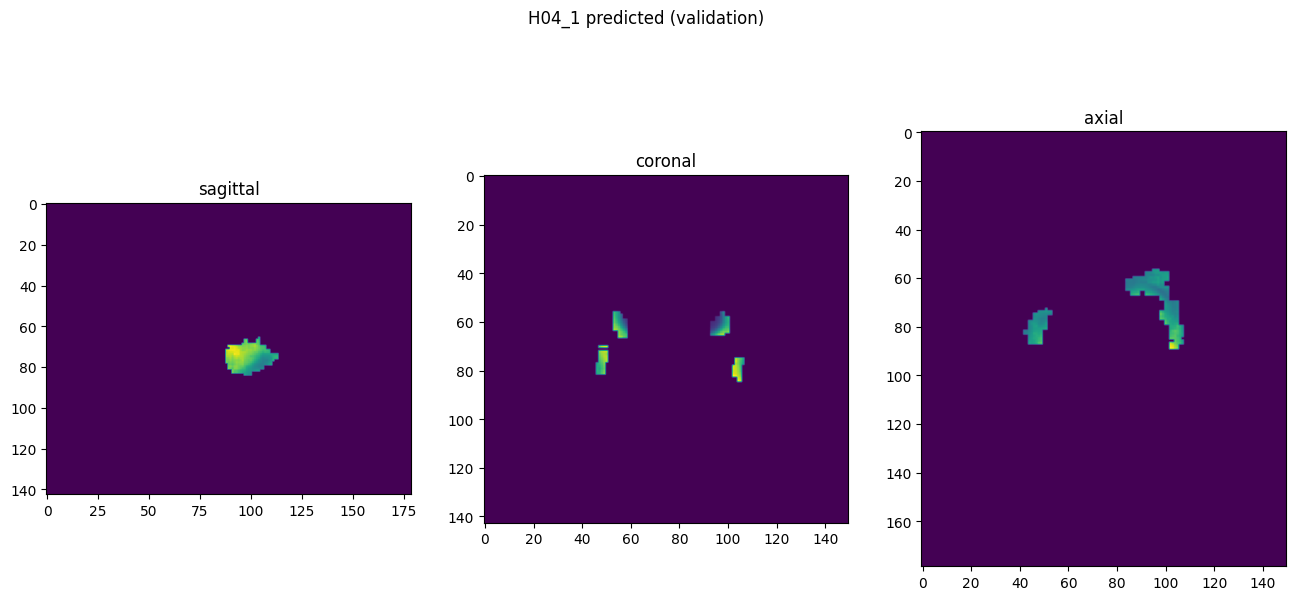

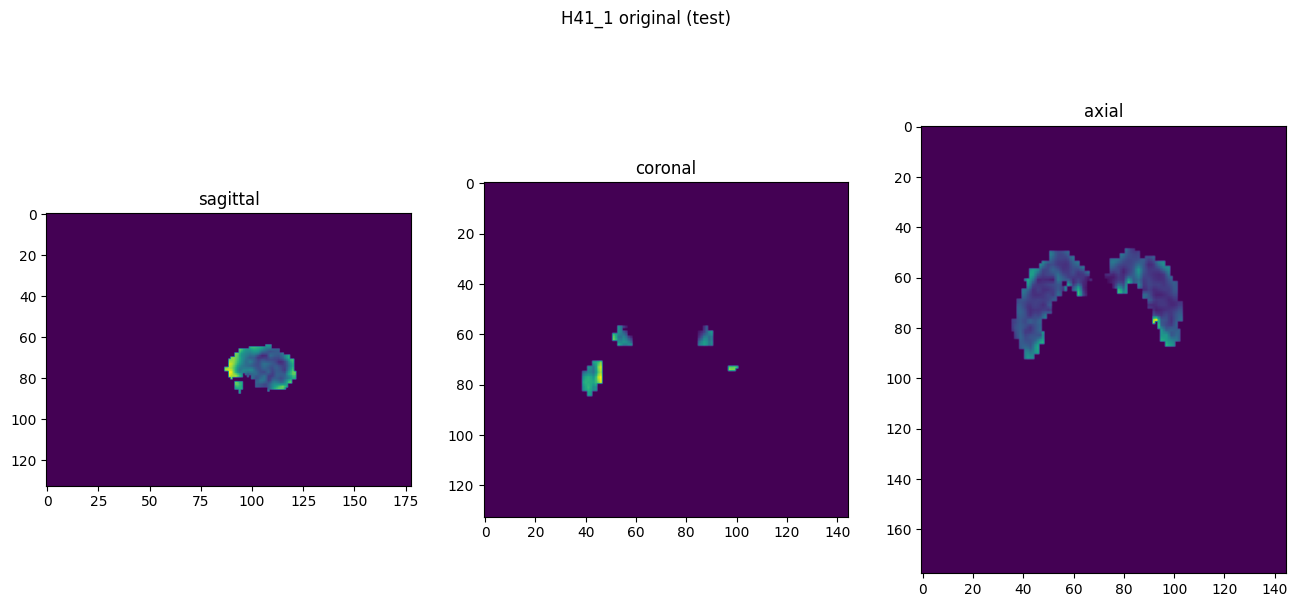

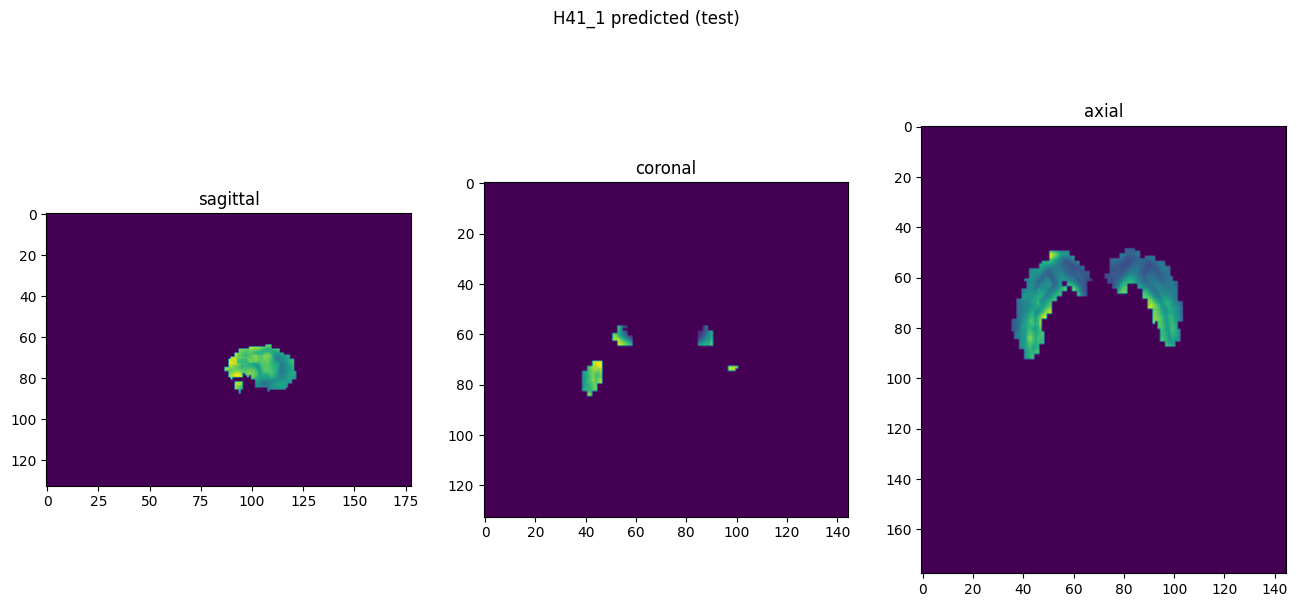

In [10]:
showResults(model, gen, threshold=None, background=False)